## Variational Quantum Generator

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer, Aer

import numpy as np
import math
from tensorflow import keras as ks
import tensorflow as tf

import matplotlib.pyplot as plt

In [91]:
class DataGenerator():
    
    def __init__(self, n_points=500):
        mu = 0.10
        sigma = 0.02
        self.n_points = n_points
        self.distribution = np.random.normal(mu, sigma, self.n_points)
    

Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
decoding_layer (Dense)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 50)                100       
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Generating fake samples for training
Iterat

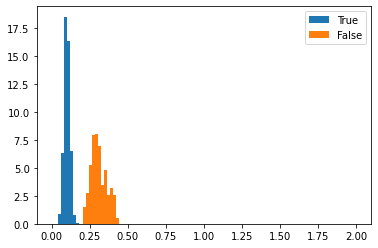

Generating fake samples for training
Iteration 1 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.20956425826536013
Generating fake samples for training
Iteration 2 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.1338479037455905
Generating fake samples for training
Iteration 3 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.07735821430020119
Generating fake samples for training
Iteration 4 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.04222063390854465
Generating fake samples for training
Iteration 5 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.021056049774651375
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


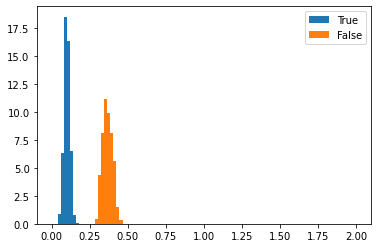

Generating fake samples for training
Iteration 6 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.009685636834919326
Generating fake samples for training
Iteration 7 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.004514510279375682
Generating fake samples for training
Iteration 8 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0019118389761649186
Generating fake samples for training
Iteration 9 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0007525555716775105
Generating fake samples for training
Iteration 10 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.00032017997198219295
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


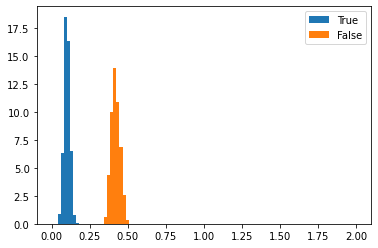

Generating fake samples for training
Iteration 11 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.00010876623278387607
Generating fake samples for training
Iteration 12 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 4.030929818059499e-05
Generating fake samples for training
Iteration 13 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 1.5814118910629046e-05
Generating fake samples for training
Iteration 14 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 5.0571078561637085e-06
Generating fake samples for training
Iteration 15 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 1.8291210185464167e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


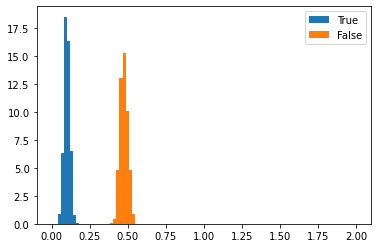

Generating fake samples for training
Iteration 16 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 6.277118191348117e-07
Generating fake samples for training
Iteration 17 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 2.011657197487218e-07
Generating fake samples for training
Iteration 18 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 8.75443312842186e-08
Generating fake samples for training
Iteration 19 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
Generating fake samples for training
Iteration 20 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


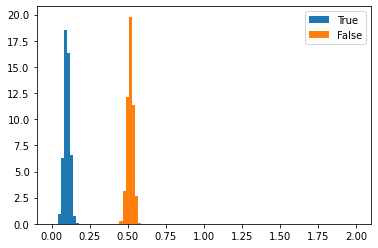

Generating fake samples for training
Iteration 21 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
Generating fake samples for training
Iteration 22 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
Generating fake samples for training
Iteration 23 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
Generating fake samples for training
Iteration 24 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0
Generating fake samples for training
Iteration 25 Real accuracy 1.0 Fake accuracy 0.0
Gen cost: 0.0


KeyboardInterrupt: 

In [93]:
class VariationalQuantumGAN():

    def __init__(self, n_epochs=50):
        super().__init__()
        # Initialize parameters
        self.backend = Aer.get_backend('statevector_simulator')
        self.backend_sim = Aer.get_backend('qasm_simulator')
        self.latent_space_size = 2
        self.variational_circuit_size = 2
        
        # Training parameters
        self.n_epochs = n_epochs
        
        # Parameters initialized as in the paper.
        self.qg_thetas = [2.3, 2.3, 1.0]
        # Build circuit with class parameters TODO: Use this to improve efficiency (if needed)
        self.qc = self.build_circuit()
        
        self.decoding_model = None
        self.build_decoding_model()
        
        self.data_generator = DataGenerator()
        self.target_dist = self.data_generator.distribution
        
        self.discriminator = self.build_discriminator()
        
        # Build gan stack for fitting the generator
        self.gan_stack = ks.Sequential()
        self.gan_stack.add(self.decoding_model)
        self.gan_stack.add(self.discriminator)
        self.gan_stack.compile(loss='binary_crossentropy')
        
    def build_circuit(self, measurement=True):
        qc = QuantumCircuit(self.variational_circuit_size, self.variational_circuit_size)
    
        # Quantum encoding.
        # z ~ U[-1, 1]
        z = np.random.uniform(-1, 1, self.latent_space_size)

        for i in range(self.latent_space_size):
            qc.rx(1/math.sin(z[i]), i + (self.variational_circuit_size - self.latent_space_size))
            qc.rz(1/math.cos(z[i]), i + (self.variational_circuit_size - self.latent_space_size))

        qc.barrier()

        # Variational Circuit
        # TODO: Scale dynamically with circuit size?
        qc.ry(self.qg_thetas[0], 0)
        qc.ry(self.qg_thetas[1], 1)
        qc.rxx(self.qg_thetas[2], 0, 1)
        qc.barrier()

        # Measurement decoding
        if measurement:
            qc.measure(0, 0)
            qc.measure(1, 1)
        
        return qc
    
    # Build circuit with params as arguments, used for parameter shift gradient calculation
    def build_circuit_with_params(self, params, measurement=True):
        qc = QuantumCircuit(self.variational_circuit_size, self.variational_circuit_size)
    
        # Quantum encoding.
        # z ~ U[-1, 1]
        z = np.random.uniform(-1, 1, self.latent_space_size)

        for i in range(self.latent_space_size):
            qc.rx(1/math.sin(z[i]), i + (self.variational_circuit_size - self.latent_space_size))
            qc.rz(1/math.cos(z[i]), i + (self.variational_circuit_size - self.latent_space_size))

        qc.barrier()

        # Variational Circuit
        # TODO: Scale dynamically with circuit size?
        qc.ry(params[0], 0)
        qc.ry(params[1], 1)
        qc.rxx(params[2], 0, 1)
        qc.barrier()

        # Measurement decoding
        if measurement:
            qc.measure(0, 0)
            qc.measure(1, 1)
        
        return qc
    
    
    
    def build_discriminator(self):
        model = ks.Sequential()
        model.add(ks.layers.Dense(50, activation='elu', input_shape=(1,)))
        model.add(ks.layers.Dense(1, activation='sigmoid'))
        
        # TODO: Investigate loss
        model.compile(loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def build_decoding_model(self):
        x = ks.layers.Input(shape=(self.variational_circuit_size,), name="input")
        decoding_layer = ks.layers.Dense(1, activation="sigmoid", name="decoding_layer")
        y = decoding_layer(x)

        self.decoding_model = ks.Model(inputs=x, outputs=y)
        self.decoding_model.summary()

#         decoding_model = keras.Sequential(
#             [
#                 ks.layers.Dense(1, activation="sigmoid", name="decoding")
#             ]
#             )
    
#         x = tf.ones((2,))
#         y = decoding_model(x)
        
#         self.decoding_model = keras.Model(inputs=x, outputs=y)
#         self.decoding_model.summary()
        
    # Generate measurement with the class 
    def generate_measurement(self, qc=None, statevector=False):
        # Somehow statevector is slower: TODO figure out. 25 seconds sv vs 15 seconds 100 shot sims.
        if not statevector:
            # TODO: change to use a class qc
            if qc is None:
                qc = self.build_circuit()
            sim_shots = 100

            job = self.backend_sim.run(qc, shots=sim_shots)
            result_sim = job.result()

            counts = result_sim.get_counts(qc)
    #         print(counts)

            classical_latent_space = np.zeros(self.variational_circuit_size)
            for count in counts.keys():
                v_n = 0
                for bit in count:
                    if bit == '1':
                        classical_latent_space[v_n] += counts[count]
                    v_n += 1

            classical_latent_space = np.stack([classical_latent_space/sim_shots])

            return classical_latent_space
        
        else:
            if qc is None:
                qc_no_measure = self.build_circuit(measurement=False)
                qc_no_measure.save_statevector()
            else:
                qc_no_measure = qc
            

            # Transpile for simulator
            simulator = Aer.get_backend('aer_simulator')
            circ = transpile(qc_no_measure, simulator)

            # Run and get statevector
            result = simulator.run(circ).result()
            statevector = result.get_statevector(circ)

            collapsed_sv = np.abs(np.stack(statevector)) ** 2

            classical_latent_space = np.zeros(self.variational_circuit_size)
            for i in range(len(collapsed_sv)):
                # Counts are fixed. CHANGE 02b TO NEW LATENT SPACE SIZE IF CHANGED
                current_count = "{0:02b}".format(i)
                for bit in range(len(current_count)):
                    if current_count[bit] == "1":
                        classical_latent_space[bit] += collapsed_sv[i]

    #             000 , 001, 010, 011, 100, 101, 110, 111

    #         print(classical_latent_space)
    #         print(collapsed_sv)

            classical_latent_space = classical_latent_space.reshape(1, self.variational_circuit_size)

            return classical_latent_space
        
    def generate_prediction(self, qc=None):
        circuit_measurement = self.generate_measurement(qc=qc)
        return self.decoding_model.predict(circuit_measurement)
    
    def generate_fake_samples(self, n):
        print("Generating fake samples for training")
        predictions = []
#         self.printProgressBar(iteration=0, total=10)
        j = 0
        for i in range(n):
            predictions.append(self.generate_prediction())
#             if i%(int(n/10)) == 0:
#                 j += 1
#                 self.printProgressBar(iteration=j, total=10)
            
        predictions = np.stack(predictions)
        predictions = predictions.reshape((n, 1))
        
        return predictions, np.zeros((n, 1))
    
    def generate_fake_samples(self, n, qc=None):
        print("Generating fake samples for training")
        predictions = []
#         self.printProgressBar(iteration=0, total=10)
        j = 0
        for i in range(n):
            predictions.append(self.generate_prediction(qc=qc))
#             if i%(int(n/10)) == 0:
#                 j += 1
#                 self.printProgressBar(iteration=j, total=10)
            
        predictions = np.stack(predictions)
        predictions = predictions.reshape((n, 1))
        
        return predictions, np.zeros((n, 1))
    
    def train(self):
        self.discriminator.summary()
        
        # TODO: Resample real distribution continuously instead of using fixed amount of points
        X_real = np.stack(self.target_dist).reshape(len(self.target_dist), 1)
        y_real = np.ones((len(self.target_dist), 1))
        
        disc_batch_size = 32
        gen_batch_size = 32
        
        for i in range(self.n_epochs):
            X_fake_sampled, y_fake_sampled = self.generate_fake_samples(int(disc_batch_size / 2))
            # Train discriminator
            # TODO: Perform basic improvements on discriminator
            # TODO: Create wasserstein critic
            
            # Select read and fake data_points, we assume N_fake == N_real (Amount fake datapoints is equal to amount of real datapoints)
            idx = np.random.choice(np.arange(len(X_real)), int(disc_batch_size / 2))
            
            # Train on real
            X_real_sampled, y_real_sampled = np.take(X_real, idx), np.take(y_real, idx)
            _, acc_real = self.discriminator.train_on_batch(X_real_sampled, y_real_sampled)
            
            # Train on fake
            _, acc_fake = self.discriminator.train_on_batch(X_fake_sampled, y_fake_sampled)
            
            print("Iteration", i, "Real accuracy", acc_real, "Fake accuracy", acc_fake)
            
            # Train generator stack
            # TODO: Figure out gradients exactly
            
            # Calculate Generator Cost
            disc_pred = 0
            for j in range(len(X_fake_sampled)):
                disc_pred -= math.log(self.discriminator.predict(X_fake_sampled[j]))/disc_batch_size
                
            print("Gen cost:", disc_pred)
            
            self.discriminator.trainable = False
            # Update Quantum and Classical part of generator with parameter shift
            for j in range(gen_batch_size):
                non_shift_qc = self.build_circuit_with_params(self.qg_thetas)
                non_shift_measurement = self.generate_measurement(qc=non_shift_qc)
#                 print(non_shift_measurement)
                non_shift_sample = self.decoding_model.predict(non_shift_measurement)
                non_shift_cost = self.discriminator.predict([non_shift_sample])
                
                self.gan_stack.train_on_batch(np.stack(non_shift_measurement), np.stack([1]))
                
                for k in range(len(self.qg_thetas)):
                    neg_shift_params = self.qg_thetas.copy()
                    neg_shift_params[k] -= math.pi/2
                    neg_shift_qc = self.build_circuit_with_params(neg_shift_params)
                    
                    neg_shift_sample = self.generate_prediction(qc=neg_shift_qc)
                    neg_shift_cost = self.discriminator.predict([neg_shift_sample])
                    
                    pos_shift_params = self.qg_thetas.copy()
                    pos_shift_params[k] -= math.pi/2
                    pos_shift_qc = self.build_circuit_with_params(pos_shift_params)
                    
                    pos_shift_sample = self.generate_prediction(qc=pos_shift_qc)
                    pos_shift_cost = self.discriminator.predict([pos_shift_sample])
                    
                    gradient = pos_shift_cost - neg_shift_cost
                    
                    self.qg_thetas[k] += gradient * non_shift_cost
            
            
            self.discriminator.trainable = True
            
            if i % 5 == 0:
                self.compare_model_to_real()
            
    def compare_model_to_real(self):
        bins = np.linspace(0, 2, 100)
        
        plt.hist(self.target_dist, bins, density=True, label="True")
        predictions = []
        self.printProgressBar(iteration=0, total=10)
        j = 0
        for i in range(self.data_generator.n_points):
            predictions.append(self.generate_prediction())
            if i%(self.data_generator.n_points/10) == 0:
                j += 1
                self.printProgressBar(iteration=j, total=10)
#                 print(str(i/self.data_generator.n_points*100) + "%")
                
        predictions = np.stack(predictions)
        predictions = predictions.reshape((self.data_generator.n_points,))

        plt.hist(predictions, bins, density=True, label="False")
        
        plt.legend()
        plt.show()
        
    def printProgressBar (self, iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
        percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
        # Print New Line on Complete
        if iteration == total: 
            print()
            
    
vqgan = VariationalQuantumGAN()
vqgan.train()
# vqgan.generate_prediction()